In [1]:
import cdms2 as cdms
import MV2 as MV
import cdtime,cdutil,genutil
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import string
import glob
import scipy.stats as stats
# Local solution
# If running remotely, uncomment the following code:
# %%bash
# git clone https://github.com/katemarvel/CMIP5_tools
# import CMIP5_tools as cmip5
import sys,os
sys.path.append("/home/kdm2144/python-utils")

import CMIP5_tools as cmip5
import DA_tools
import Plotting

from eofs.cdms import Eof
from eofs.multivariate.cdms import MultivariateEof
%matplotlib inline

computer="dester"
if computer is "laptop":
    rootdirec="/Volumes/MarvelCMIP6/DROUGHT/"
elif computer is "dester":
    rootdirec="/home/kdm2144/DROUGHT/"
else:
    rootdirec="/Users/kmarvel/Documents/DATA/"
    
vcert=stats.norm.interval(.99)[1]

#Region locations
NCA4regions={}
#Northwest (NW): (125°W–111°W, 42°N–49°N)
NCA4regions["NW"]=cdutil.region.domain(longitude=(-125,-111),latitude=(42,49))
#Southwest (SW): (124°W–102°W, 31°N–42°N)
NCA4regions["SW"]=cdutil.region.domain(longitude=(-124,-102),latitude=(31,42))
#Upper Great Plains (GPu): (116°W–95°W, 40°N–49°N)
NCA4regions["GPu"]=cdutil.region.domain(longitude=(-116,-95),latitude=(40,49))
#Lower Great Plains (GPl): (107°W–93°W, 26°N–40°N)
NCA4regions["GPl"]=cdutil.region.domain(longitude=(-107,-93),latitude=(26,40))
#Midwest (MW): (97°W–80°W, 36°N–50°N)
NCA4regions["MW"]=cdutil.region.domain(longitude=(-97,-80),latitude=(36,50))
#Northeast (NE): (82°W–67°W, 37°N–48°N)
NCA4regions["NE"]=cdutil.region.domain(longitude=(-82,-67),latitude=(37,48))
#Southeast (SE): (95°W–76°W, 25°N–39°N)
NCA4regions["SE"]=cdutil.region.domain(longitude=(-95,-76),latitude=(25,39))


import DroughtHelper as dh
from importlib import reload


In [3]:
X=dh.TOE("mrros","NW")

/home/kdm2144/miniconda3/envs/cdatpy3/lib/python3.6/site-packages/numpy/ma/core.py:3174: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  dout = self.data[indx]


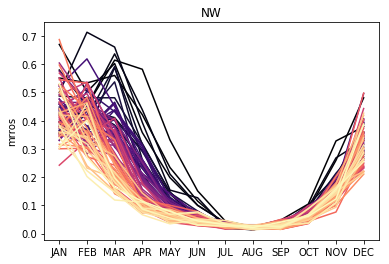

In [4]:
X.plot_seasonal_trends()

In [6]:
X.concatenate_piControl().shape

(13, 12)

In [7]:
variable="mrros"
experiment="piControl"
region="SW"

In [9]:
fnames=sorted(dh.get_ensemble_filenames(variable,region,experiment))


['/home/kdm2144/DROUGHT/NCA4/SW/mrros/piControl/mrros.piControl.ACCESS-CM2.r1i1p1f1.nc',
 '/home/kdm2144/DROUGHT/NCA4/SW/mrros/piControl/mrros.piControl.ACCESS-ESM1-5.r1i1p1f1.nc',
 '/home/kdm2144/DROUGHT/NCA4/SW/mrros/piControl/mrros.piControl.CESM2-WACCM.r1i1p1f1.nc',
 '/home/kdm2144/DROUGHT/NCA4/SW/mrros/piControl/mrros.piControl.CESM2.r1i1p1f1.nc',
 '/home/kdm2144/DROUGHT/NCA4/SW/mrros/piControl/mrros.piControl.CanESM5.r1i1p1f1.nc',
 '/home/kdm2144/DROUGHT/NCA4/SW/mrros/piControl/mrros.piControl.CanESM5.r1i1p2f1.nc',
 '/home/kdm2144/DROUGHT/NCA4/SW/mrros/piControl/mrros.piControl.EC-Earth3-Veg.r1i1p1f1.nc',
 '/home/kdm2144/DROUGHT/NCA4/SW/mrros/piControl/mrros.piControl.EC-Earth3.r1i1p1f1.nc',
 '/home/kdm2144/DROUGHT/NCA4/SW/mrros/piControl/mrros.piControl.INM-CM4-8.r1i1p1f1.nc',
 '/home/kdm2144/DROUGHT/NCA4/SW/mrros/piControl/mrros.piControl.INM-CM5-0.r1i1p1f1.nc',
 '/home/kdm2144/DROUGHT/NCA4/SW/mrros/piControl/mrros.piControl.IPSL-CM6A-LR.r1i1p1f1.nc',
 '/home/kdm2144/DROUGHT/NC

In [32]:
models=dh.get_ok_models("NW",variables=['mrro'])
model=models[0]

In [13]:
season="MAM"
self=X
experiment="piControl"
fnames=sorted(dh.get_ensemble_filenames(self.variable,self.region,experiment))
#models=sorted(self.ensemble_dict.keys())
models=dh.get_ok_models(self.region)

nmod=len(models)
ntimes=[]
model_names=[]
#Loop over without loading data to figure out the shortest length control run
for model in models:
   # print(model)
    I=np.where([x.split(".")[2]==model for x in fnames])[0]
    if len(I)>0:
        first_member=int(I[0])

        fname=fnames[first_member]

        model_names+=[fname]
        f=cdms.open(fname)
        ntimes+=[int(f[self.variable].shape[0])]
        f.close()
L=np.min(ntimes)
#Set the time axis to be the time axis of the shortest control rin
imin=np.argmin(ntimes)

fshortest=model_names[imin]
f=cdms.open(fshortest)
tax=f(self.variable).getTime()
tax.id='time'
tax.designateTime()
f.close()
#Load data
#SingleMember=np.ma.zeros((len(model_names),L))+1.e20
SingleMember=np.ma.zeros((nmod,L))+1.e20
i=0
for model in models:
    I=np.where([x.split(".")[2]==model for x in fnames])[0]
    if len(I)>0:
        first_member=I[0]
        fname=fnames[first_member]
        f=cdms.open(fname)
        vdata=f(self.variable)

        SingleMember[i]=vdata[:L]
        i+=1
    else:
        if self.verbose:
            print("No piControl data for "+model+" "+self.variable)

    f.close()

#Historical units are already converted; need to convert piControl from 
#kg m-2 s-1 to mm day-1
#if self.variable in ["pr","evspsbl","prsn","mrros","mrro"]:
 #   SingleMember = SingleMember*86400.
SingleMember=MV.masked_where(np.abs(SingleMember)>1.e10,SingleMember)
SingleMember=MV.array(SingleMember)
SingleMember.setAxis(1,tax)

SingleMember.setAxis(0,cmip5.make_model_axis(models))
###KLUDGE: FIRST YEAR IS ZERO- FIX THIS IN DOWNLOADER
SingleMember=MV.masked_where(SingleMember==0,SingleMember)
# if self.variable in ["mrsos","mrso"]:
#     if not raw:
#         SingleMember=self.standardize_zscore(SingleMember)
# else:
#     if not raw:
#         SingleMember=self.convert_to_percentage(SingleMember)
#if season is None:
    #return SingleMember
cdutil.setTimeBoundsMonthly(SingleMember)
seasonal=getattr(cdutil,season).departures(SingleMember)

#return DA_tools.concatenate_this(seasonal,compressed=compressed)


/home/kdm2144/miniconda3/envs/cdatpy3/lib/python3.6/site-packages/numpy/ma/core.py:3206: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  mout = _mask[indx]


In [32]:
badmod=models[np.argmin(ntimes)]
models[2]

'CESM2'

In [21]:
import pandas as pd
ingrid_cmip6 = pd.read_csv("mary_cmip6.csv")

In [23]:
df1 = ingrid_cmip6[(ingrid_cmip6.source_id==badmod)\
                                   & (ingrid_cmip6.variable_id==X.variable) & \
                                   (ingrid_cmip6.experiment_id == "piControl")&\
                                  (ingrid_cmip6.member_id == "r1i1p1f1")]

In [24]:
df1

,activity_id,experiment_id,file_basename,file_dirname,file_fullpath,grid_label,institution_id,member_id,mip_era,source_id,table_id,time_range,variable_id,tracking_id,version
85918,CMIP,piControl,mrros_Lmon_EC-Earth3_piControl_r1i1p1f1_gr_243...,/m3/haibo/CMIP6mon/CMIP/EC-Earth-Consortium/EC...,/m3/haibo/CMIP6mon/CMIP/EC-Earth-Consortium/EC...,gr,EC-Earth-Consortium,r1i1p1f1,CMIP6,EC-Earth3,Lmon,243001-243012,mrros,NaN,v20190712
85919,CMIP,piControl,mrros_Lmon_EC-Earth3_piControl_r1i1p1f1_gr_243...,/m3/haibo/CMIP6mon/CMIP/EC-Earth-Consortium/EC...,/m3/haibo/CMIP6mon/CMIP/EC-Earth-Consortium/EC...,gr,EC-Earth-Consortium,r1i1p1f1,CMIP6,EC-Earth3,Lmon,243101-243112,mrros,NaN,v20190712
85920,CMIP,piControl,mrros_Lmon_EC-Earth3_piControl_r1i1p1f1_gr_243...,/m3/haibo/CMIP6mon/CMIP/EC-Earth-Consortium/EC...,/m3/haibo/CMIP6mon/CMIP/EC-Earth-Consortium/EC...,gr,EC-Earth-Consortium,r1i1p1f1,CMIP6,EC-Earth3,Lmon,243201-243212,mrros,NaN,v20190712
85921,CMIP,piControl,mrros_Lmon_EC-Earth3_piControl_r1i1p1f1_gr_243...,/m3/haibo/CMIP6mon/CMIP/EC-Earth-Consortium/EC...,/m3/haibo/CMIP6mon/CMIP/EC-Earth-Consortium/EC...,gr,EC-Earth-Consortium,r1i1p1f1,CMIP6,EC-Earth3,Lmon,243301-243312,mrros,NaN,v20190712
85922,CMIP,piControl,mrros_Lmon_EC-Earth3_piControl_r1i1p1f1_gr_243...,/m3/haibo/CMIP6mon/CMIP/EC-Earth-Consortium/EC...,/m3/haibo/CMIP6mon/CMIP/EC-Earth-Consortium/EC...,gr,EC-Earth-Consortium,r1i1p1f1,CMIP6,EC-Earth3,Lmon,243401-243412,mrros,NaN,v20190712
85923,CMIP,piControl,mrros_Lmon_EC-Earth3_piControl_r1i1p1f1_gr_243...,/m3/haibo/CMIP6mon/CMIP/EC-Earth-Consortium/EC...,/m3/haibo/CMIP6mon/CMIP/EC-Earth-Consortium/EC...,gr,EC-Earth-Consortium,r1i1p1f1,CMIP6,EC-Earth3,Lmon,243501-243512,mrros,NaN,v20190712
85924,CMIP,piControl,mrros_Lmon_EC-Earth3_piControl_r1i1p1f1_gr_243...,/m3/haibo/CMIP6mon/CMIP/EC-Earth-Consortium/EC...,/m3/haibo/CMIP6mon/CMIP/EC-Earth-Consortium/EC...,gr,EC-Earth-Consortium,r1i1p1f1,CMIP6,EC-Earth3,Lmon,243601-243612,mrros,NaN,v20190712
85925,CMIP,piControl,mrros_Lmon_EC-Earth3_piControl_r1i1p1f1_gr_243...,/m3/haibo/CMIP6mon/CMIP/EC-Earth-Consortium/EC...,/m3/haibo/CMIP6mon/CMIP/EC-Earth-Consortium/EC...,gr,EC-Earth-Consortium,r1i1p1f1,CMIP6,EC-Earth3,Lmon,243701-243712,mrros,NaN,v20190712
85926,CMIP,piControl,mrros_Lmon_EC-Earth3_piControl_r1i1p1f1_gr_243...,/m3/haibo/CMIP6mon/CMIP/EC-Earth-Consortium/EC...,/m3/haibo/CMIP6mon/CMIP/EC-Earth-Consortium/EC...,gr,EC-Earth-Consortium,r1i1p1f1,CMIP6,EC-Earth3,Lmon,243801-243812,mrros,NaN,v20190712
85927,CMIP,piControl,mrros_Lmon_EC-Earth3_piControl_r1i1p1f1_gr_243...,/m3/haibo/CMIP6mon/CMIP/EC-Earth-Consortium/EC...,/m3/haibo/CMIP6mon/CMIP/EC-Earth-Consortium/EC...,gr,EC-Earth-Consortium,r1i1p1f1,CMIP6,EC-Earth3,Lmon,243901-243912,mrros,NaN,v20190712


In [28]:
external_drive="/home/kdm2144/"

import requests
import pandas as pd
#def pull_data(curr_mod,curr_var,experiment_id,member_id,overwrite=False):
curr_mod=badmod
curr_var="mrros"
experiment_id="piControl"
member_id="r1i1p1f1"
overwrite=True
# Baseline directory
base_dir   = 'http://mary.ldeo.columbia.edu:81/CMIP6/.'
# Write directory

base_write_dir= external_drive+'DROUGHT/DOWNLOADED_RAW/'
df_proclist = pd.DataFrame(columns=['model','sim','ensemble','variable'])
ingrid_cmip6 = pd.read_csv("mary_cmip6.csv")


write_dir = base_write_dir+curr_var+"/"+curr_mod+"/"
write_stem = curr_var+"."+experiment_id+"."+curr_mod+"."+member_id+".*.nc"

#If the directory doesn't exist already, make it
os.makedirs(os.path.join(base_write_dir, curr_var, curr_mod),exist_ok=True)

if not overwrite:
    already_exist=glob.glob(write_dir+write_stem)
    if len(already_exist)!=0:
        print("Already done!")
        #return False
#rips=np.unique(np.array(df1.member_id))

df1 = ingrid_cmip6[(ingrid_cmip6.source_id==curr_mod)\
                               & (ingrid_cmip6.variable_id==curr_var) & \
                               (ingrid_cmip6.experiment_id == experiment_id)&\
                              (ingrid_cmip6.member_id == member_id)]

#Construct openDAP link
nfiles,nidentifiers=df1.shape
times=np.sort(np.array(df1.time_range))
i_ens=np.where(df1.time_range==times[0])[0]
time_range=times[0]

for time_range in times:
    # Construct Remote OpenDAP Link
    i_ens=np.where(df1.time_range==time_range)[0][0]
    nc_link = base_dir+df1.activity_id.iloc[i_ens]+'/.'+df1.institution_id.iloc[i_ens]+'/.'+curr_mod+'/.'+experiment_id+'/.'+df1.member_id.iloc[i_ens]+'/.'+df1.table_id.iloc[i_ens]+ \
                        '/.'+curr_var+'/.'+df1.grid_label.iloc[i_ens]+'/.'+df1.version.iloc[i_ens]+'/.'+df1.file_basename.iloc[i_ens]+'/.'+curr_var+'/dods'
    request = requests.get(nc_link)
    if request.status_code == 200:
        #Get the data
        f=cdms.open(nc_link)
        data=f(curr_var)
        tax=data.getTime()
        tax.id="time"
        latax=data.getLatitude()
        lonax=data.getLongitude()
        #reshape it to years and months
        ntime=data.shape[0]
        nyears=int(ntime/12)
        rdata=data.reshape((nyears,12)+data.shape[1:])
        for i in range(nyears):
            yeardata=rdata[i]
            #Make the time axis
            tax_trunc=cdms.createAxis(tax[12*i:12*(i+1)])
            tax_trunc.designateTime()
            for key in tax.attributes.keys():
                setattr(tax_trunc,key,tax.attributes[key])
            yeardata.setAxis(0,tax_trunc)
            yeardata.setAxis(1,latax)
            yeardata.setAxis(2,lonax)
            #get the start year for labeling purposes
            year=str(tax_trunc.asComponentTime()[0].year)
            writename = curr_var+"."+experiment_id+"."+curr_mod+"."+member_id+"."+year.zfill(4)+".nc"
            fw=cdms.open(write_dir+writename,"w")
            fw.write(yeardata)
            fw.close()
        f.close()
    #return True




/home/kdm2144/miniconda3/envs/cdatpy3/lib/python3.6/site-packages/numpy/ma/core.py:3174: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  dout = self.data[indx]
/home/kdm2144/miniconda3/envs/cdatpy3/lib/python3.6/site-packages/numpy/ma/core.py:3206: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  mout = _mask[indx]


In [ ]:
pull_data()